# 2015 Street Tree Census - Tree Data

*  DSC 550
*  10.3 Term Project
*  Sherrell Bacon

## Questions to Explore

1. What are the most common tree species in each borough?
2. Is there a relationship between tree health and stewardship activity?
3. Are tree diameters (dbh) larger in some boroughs than others?

The goal of this project is to predict the health condition of trees in New York City using tree-specific and environmental features collected during the 2015 NYC Street Tree Census. The target variable for this model is health, a categorical label with values such as Good, Fair, and Poor. Accurate prediction of tree health is important for prioritizing maintenance and guiding urban forestry decisions.

In [1]:
# import libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
from pytz import all_timezones
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

## API Request

In [2]:
# create api request. Due to size of the dataset it has been limited to 400K rows
api_url = "https://data.cityofnewyork.us/resource/uvpi-gqnh.json?$limit=400000"
response = requests.get(api_url)

# get response and turn data into a dataframe 
if response.status_code == 200:
    data = response.json()
    # convert to DataFrame
    data = pd.DataFrame(data)
    print(data.head())

  tree_id block_id               created_at tree_dbh stump_diam curb_loc  \
0  180683   348711  2015-08-27T00:00:00.000        3          0   OnCurb   
1  200540   315986  2015-09-03T00:00:00.000       21          0   OnCurb   
2  204026   218365  2015-09-05T00:00:00.000        3          0   OnCurb   
3  204337   217969  2015-09-05T00:00:00.000       10          0   OnCurb   
4  189565   223043  2015-08-30T00:00:00.000       21          0   OnCurb   

  status health                           spc_latin       spc_common  ...  \
0  Alive   Fair                         Acer rubrum        red maple  ...   
1  Alive   Fair                   Quercus palustris          pin oak  ...   
2  Alive   Good  Gleditsia triacanthos var. inermis      honeylocust  ...   
3  Alive   Good  Gleditsia triacanthos var. inermis      honeylocust  ...   
4  Alive   Good                     Tilia americana  American linden  ...   

   boro_ct     state     latitude     longitude         x_sp         y_sp  \
0  

# Milestone 1

### EDA

In [3]:
# Verify the count of rows and column in the dataset 
data.shape

(400000, 45)

In [4]:
# Retrieve summary statistics to understand the distribution and spread of the data
data.describe()

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council_district,census_tract,bin,bbl
count,400000,400000,400000,400000,400000,400000,400000,381387,381388,381388,...,400000,400000,400000,400000,400000,400000,396945,396945,395267,395267
unique,400000,64664,411,124,94,2,3,3,129,129,...,2098,1,397466,397667,399188,399541,51,1303,231199,224782
top,180683,602362,2015-10-27T00:00:00.000,4,0,OnCurb,Alive,Good,Platanus x acerifolia,London planetree,...,5020801,New York,40.61097709,-74.15686098,940697.4014,161910.8114,51,20801,2000000,2051410120
freq,1,358,6827,36254,389428,384870,381388,310240,48355,48355,...,3684,400000,28,29,28,28,42479,3523,321,243


In [5]:
# Review data types
data.dtypes

tree_id             object
block_id            object
created_at          object
tree_dbh            object
stump_diam          object
curb_loc            object
status              object
health              object
spc_latin           object
spc_common          object
steward             object
guards              object
sidewalk            object
user_type           object
problems            object
root_stone          object
root_grate          object
root_other          object
trunk_wire          object
trnk_light          object
trnk_other          object
brch_light          object
brch_shoe           object
brch_other          object
address             object
zipcode             object
zip_city            object
cb_num              object
borocode            object
boroname            object
cncldist            object
st_assem            object
st_senate           object
nta                 object
nta_name            object
boro_ct             object
state               object
l

In [6]:
# Check for rows with missing data that may need to be imputed
missing = data.isnull().sum().sort_values(ascending= False)
print(missing[missing >0])

problems            18633
health              18613
sidewalk            18613
spc_common          18612
guards              18612
steward             18612
spc_latin           18612
bbl                  4733
bin                  4733
council_district     3055
census_tract         3055
dtype: int64


In [7]:
# Impute columns with missing categorical data with 'unknown'
columns_to_impute = ['spc_common', 'health','sidewalk', 'spc_latin']

In [8]:
# Loop through each column and impute 'Unknown' where status is 'Stump' and value is missing. 
for columns in columns_to_impute:
     data.loc[(data['status'] == 'Stump') & (data[columns].isna()), columns] = 'Unknown'

In [9]:
# Verify the results of loop
data[data['status'] == 'Stump'][columns_to_impute].isnull().sum()

spc_common    0
health        0
sidewalk      0
spc_latin     0
dtype: int64

In [10]:
# Make sure tree_dbh and stump_diam are numeric
data['tree_dbh'] = pd.to_numeric(data['tree_dbh'], errors='coerce')
data['stump_diam'] = pd.to_numeric(data['stump_diam'], errors='coerce')
data['steward'] = data['steward'].fillna('None')
data['health'] = data['health'].astype('category')

count    400000.000000
mean         11.080842
std           8.699940
min           0.000000
25%           4.000000
50%           9.000000
75%          16.000000
max         450.000000
Name: tree_dbh, dtype: float64


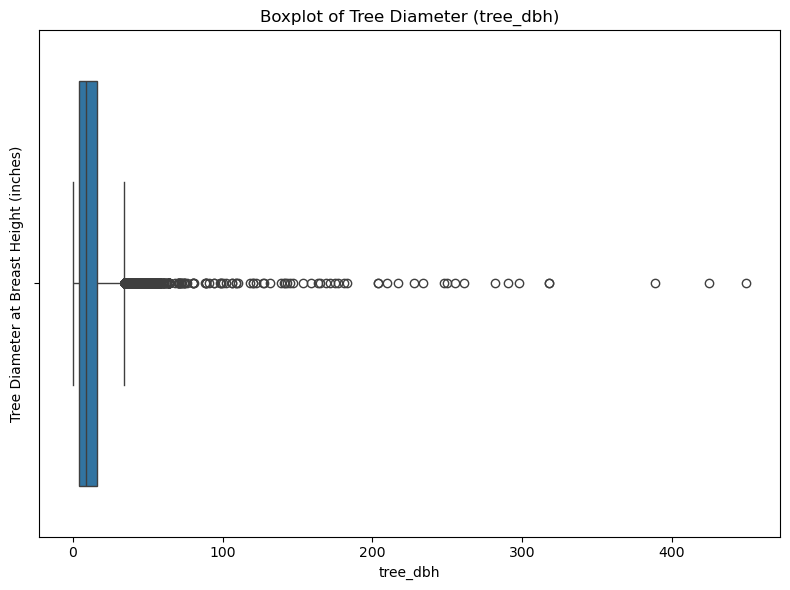

In [11]:
print(data['tree_dbh'].describe())
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['tree_dbh'])
plt.title('Boxplot of Tree Diameter (tree_dbh)')
plt.ylabel('Tree Diameter at Breast Height (inches)')
plt.tight_layout()

plt.show()

In [12]:
print(data['tree_dbh'].describe())
print(data['tree_dbh'].value_counts().sort_index().tail(10))  # See largest values

count    400000.000000
mean         11.080842
std           8.699940
min           0.000000
25%           4.000000
50%           9.000000
75%          16.000000
max         450.000000
Name: tree_dbh, dtype: float64
tree_dbh
250    1
255    1
261    1
282    1
291    1
298    1
318    2
389    1
425    1
450    1
Name: count, dtype: int64


Diameter of the tree, measured at approximately 54" / 137cm above the ground. Data was collected for both living and dead trees; for stumps, use stump_diam

In [13]:
# Create new column: 'combined_diameter.' When the tree diameter is 0 fill it with the stump diameter 
data['combined_diameter'] = np.where(
    data['tree_dbh'] > 0,
    data['tree_dbh'],
    data['stump_diam']
)

In [14]:
# Avoid log(0)
data['combined_diameter_log'] = np.log1p(data['combined_diameter'])

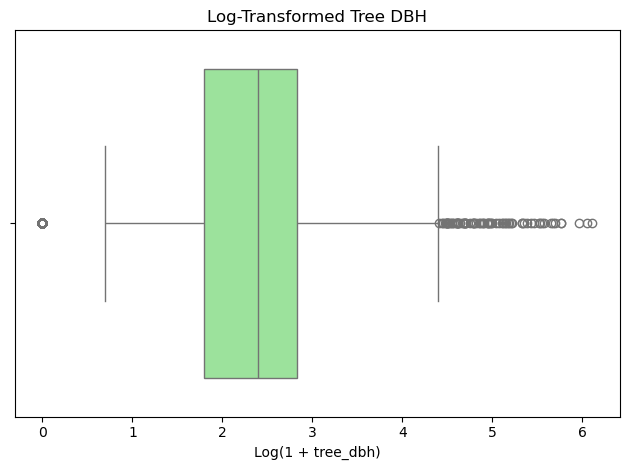

In [15]:
sns.boxplot(x=data['combined_diameter_log'], color='lightgreen')
plt.title("Log-Transformed Tree DBH")
plt.xlabel("Log(1 + tree_dbh)")
plt.tight_layout()
plt.show()

In [16]:
# set plalette for charts
sns.set_palette("Paired")

In [17]:
#Top 5 Tree Species by Borough
top_species = (data.groupby(['boroname', 'spc_common'])
                 .size()
                 .reset_index(name='count')
                 .sort_values(['boroname', 'count'], ascending=[True, False]))

top5_species = top_species.groupby('boroname').head(5)

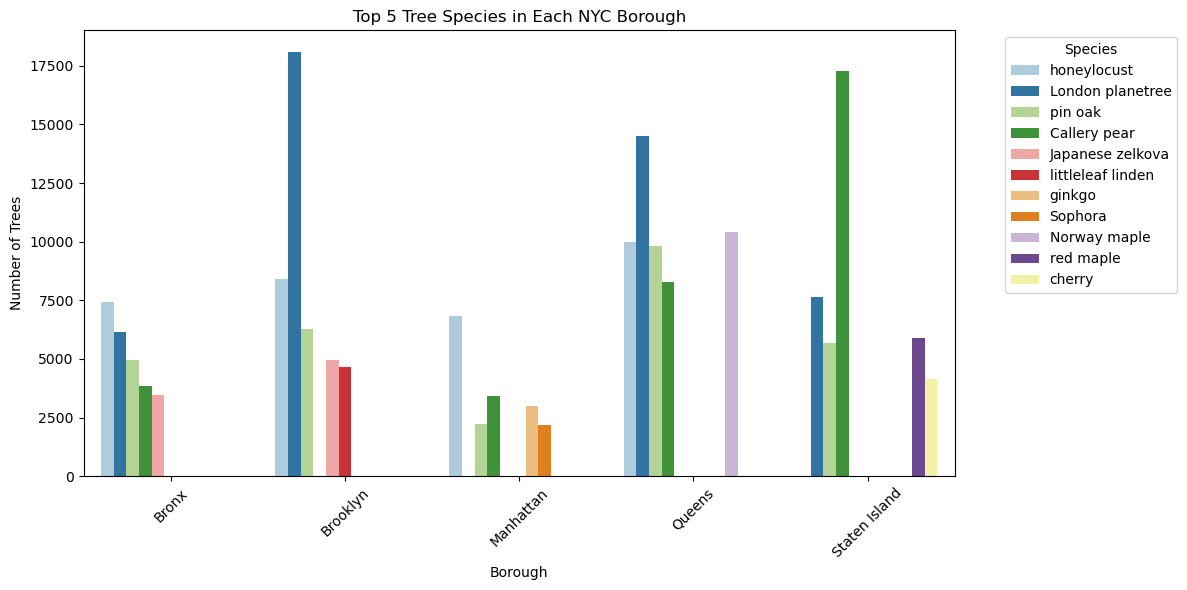

In [18]:
# create a plot showing the top 5 tree species by borough
plt.figure(figsize=(12, 6))
sns.barplot(data=top5_species, x='boroname', y='count', hue='spc_common')
plt.title('Top 5 Tree Species in Each NYC Borough')
plt.ylabel('Number of Trees')
plt.xlabel('Borough')
plt.xticks(rotation=45)
plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout()
plt.show()

Each borough has a slightly different mix of tree species. For example, London Planetrees dominate Brooklyn and Queens, while Callery Pear is more common in Statan Island.

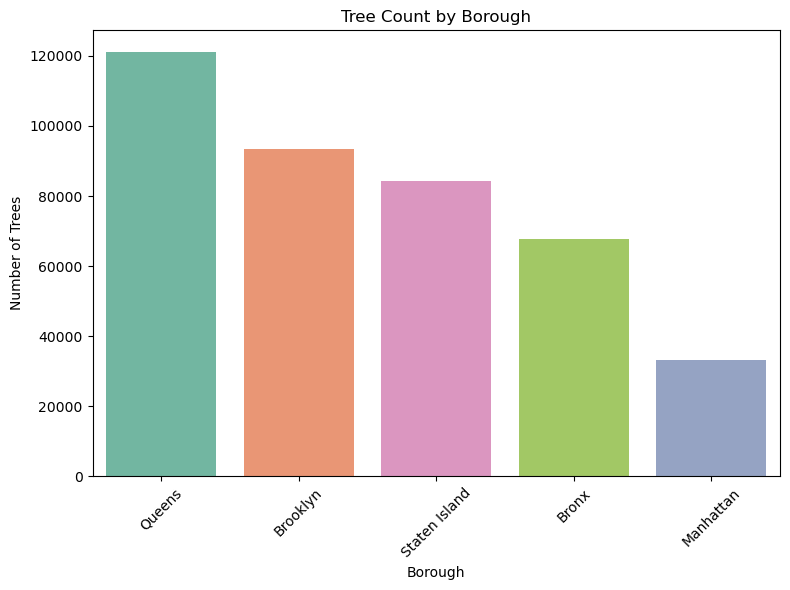

In [19]:
# Tree Counts by Borough
plt.figure(figsize=(8,6))
sns.countplot(data=data, x='boroname', order=data['boroname'].value_counts().index, hue='boroname', palette='Set2')
plt.title("Tree Count by Borough")
plt.xlabel("Borough")
plt.ylabel("Number of Trees")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

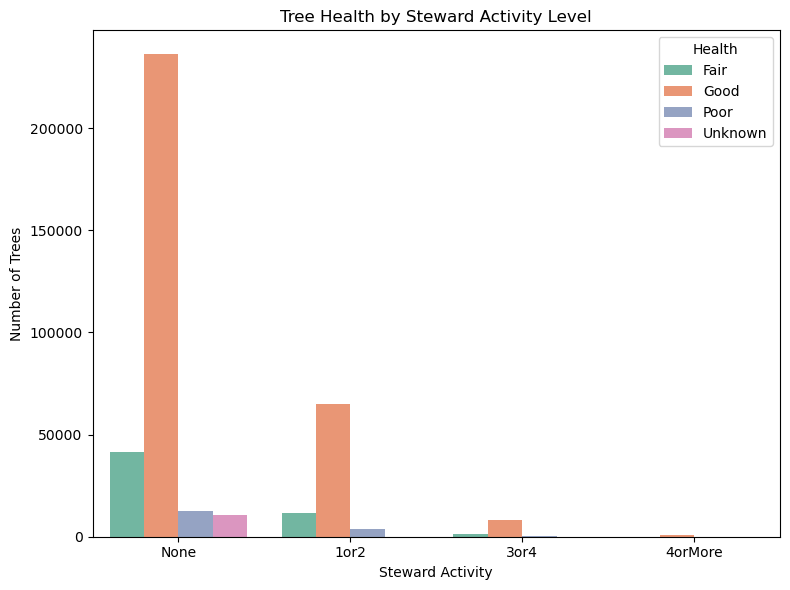

In [20]:
# Tree Health by Steward Activity
health_steward = data[data['health'].notna() & data['steward'].notna()]

plt.figure(figsize=(8, 6))
sns.countplot(data=health_steward, x='steward', hue='health', palette='Set2')
plt.title('Tree Health by Steward Activity Level')
plt.xlabel('Steward Activity')
plt.ylabel('Number of Trees')
plt.legend(title='Health')
plt.tight_layout()
plt.show()

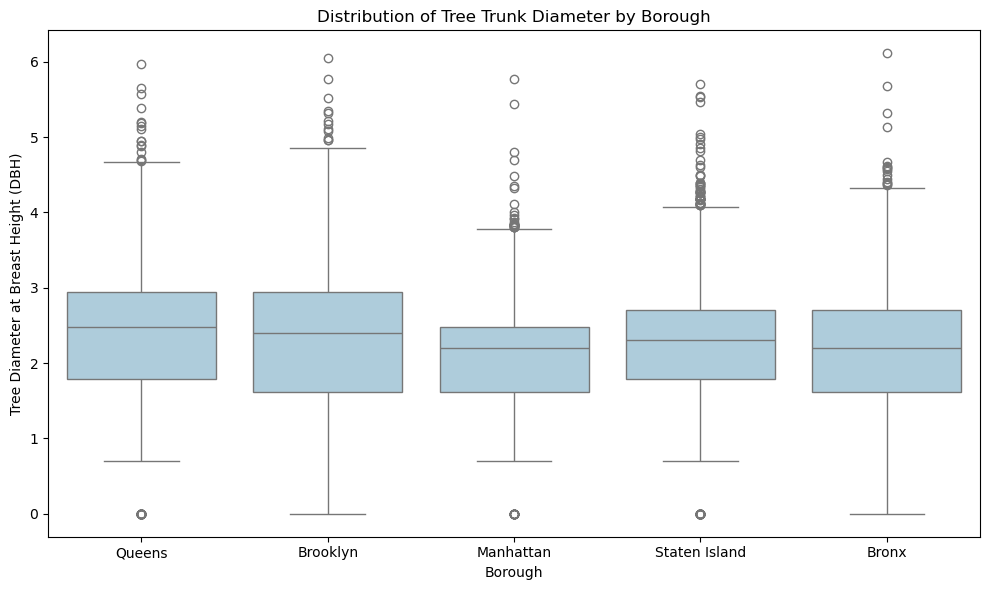

In [21]:
# Boxplot of Tree Diameter (DBH) by Borough
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='boroname', y='combined_diameter_log')
plt.title('Distribution of Tree Trunk Diameter by Borough')
plt.ylabel('Tree Diameter at Breast Height (DBH)')
plt.xlabel('Borough')
plt.tight_layout()
plt.show()

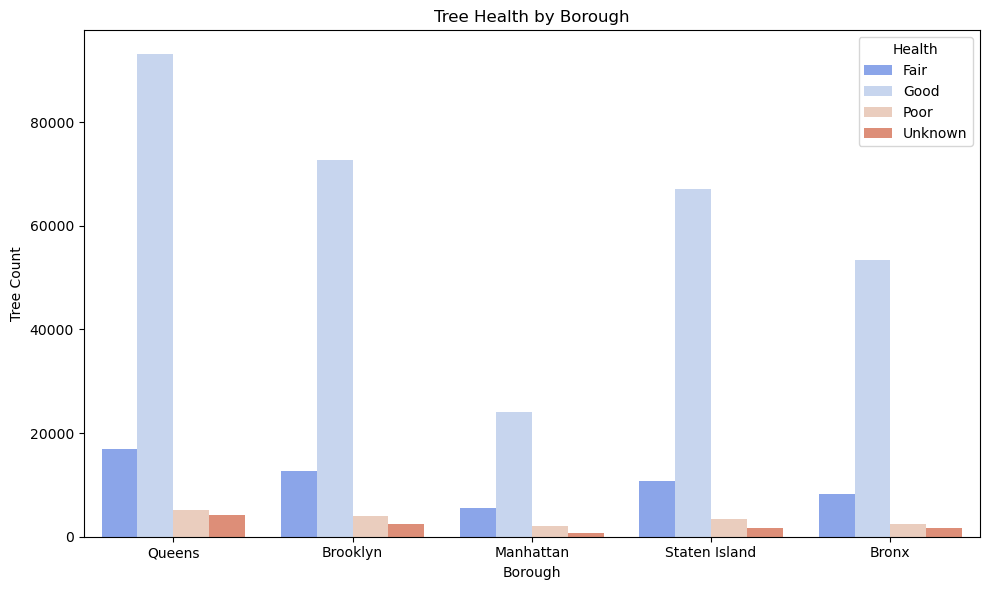

In [22]:
# Tree Health Distribution Across Boroughs
plt.figure(figsize=(10,6))
sns.countplot(data=data, x='boroname', hue='health', palette='coolwarm')
plt.title("Tree Health by Borough")
plt.xlabel("Borough")
plt.ylabel("Tree Count")
plt.legend(title="Health")
plt.tight_layout()

Most trees are in "Good" health, but some boroughs like the Bronx may have a higher proportion of "Fair" or "Poor" trees. This indicates the need for targeted maintenance.

In [23]:
# Count trees by species
top_species = data['spc_common'].value_counts().nlargest(10).index

# Filter data for just those top species
top_df = data[data['spc_common'].isin(top_species)]

# Group by species and health
species_health = top_df.groupby(['spc_common', 'health']).size().unstack().fillna(0)


/var/folders/rm/9b6561r12137sm0p138y31940000gn/T/ipykernel_5451/1307337393.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  species_health = top_df.groupby(['spc_common', 'health']).size().unstack().fillna(0)


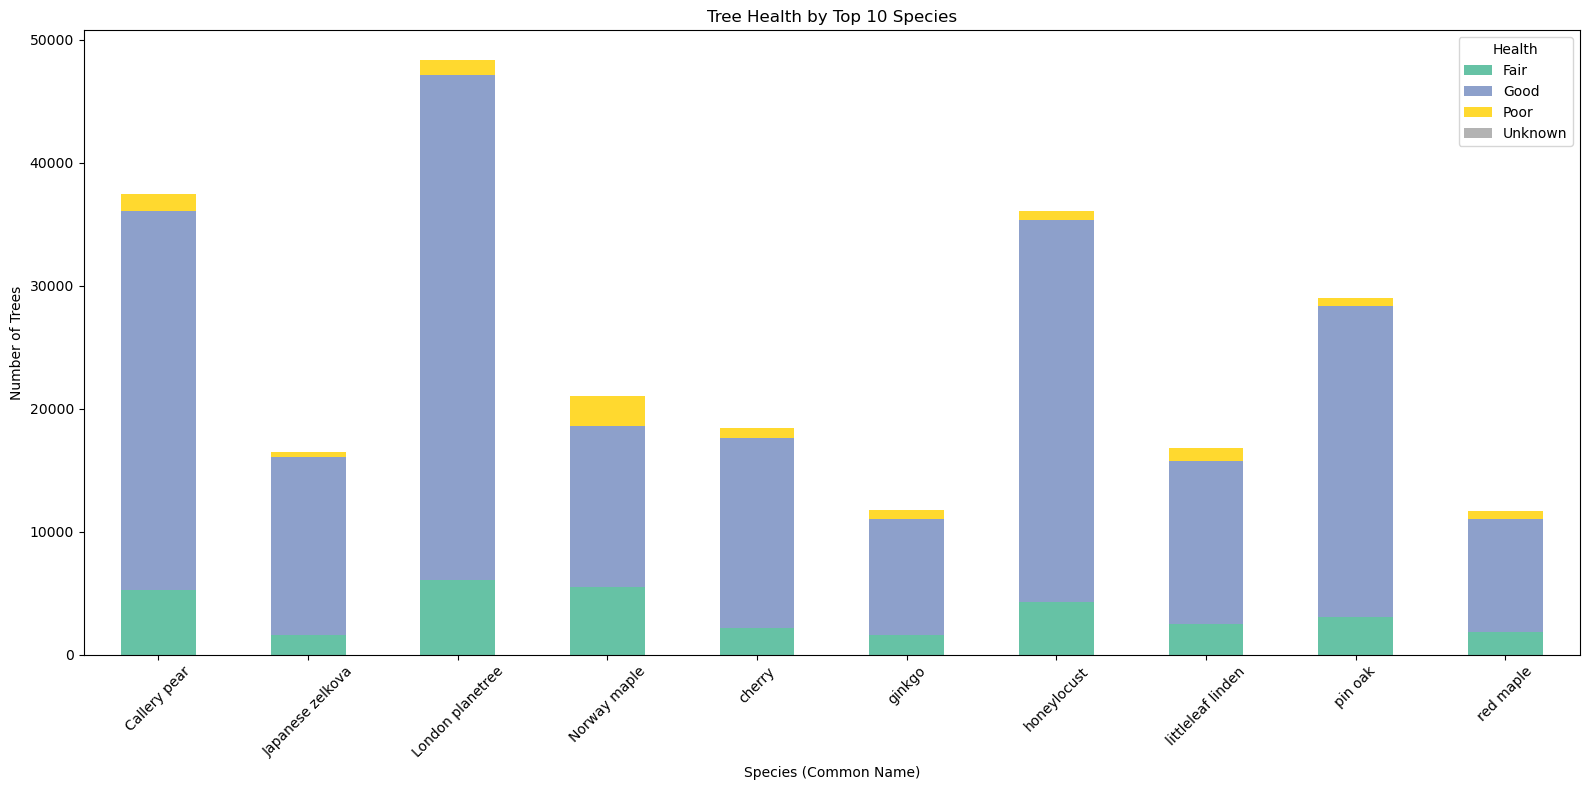

In [24]:
# Plot stacked bar chart
species_health.plot(kind='bar', stacked=True, colormap='Set2', figsize=(16, 8))
plt.title('Tree Health by Top 10 Species')
plt.xlabel('Species (Common Name)')
plt.ylabel('Number of Trees')
plt.xticks(rotation=45)
plt.legend(title='Health')
plt.tight_layout()
plt.show()

# Milestone 2

Modeling Approach:

The model attempts to classify trees into health categories using predictors like tree_dbh (diameter at breast height), species, steward, sidewalk, and other

In [25]:
# Tree size category
data['size_category'] = pd.cut(data['tree_dbh'],
                                bins=[0, 10, 20, 30, 100],
                                labels=['Small', 'Medium', 'Large', 'XL'])

Created a new column for binned tree size

In [26]:
# Standardizing missing values
data['steward'] = data['steward'].fillna('None')

#### Categorical to consistent categories
#### Some columns had inconsistent labels or missing values. These were cleaned up.

In [31]:
# Drop rows where the target or critical features are missing
features = ['spc_common', 'boroname', 'steward', 'status', 'combined_diameter', 'size_category']
target = 'health'

In [32]:
# Filter for living trees and relevant health statuses as per your description
df = data[features + [target]].dropna()
df = df[df['health'].isin(['Good', 'Fair', 'Poor'])]

Data Extraction / Selection - Only living trees were selected for modeling since the target variable health is only applicable when the tree is alive

In [33]:
# Separate features and target
X = df[features]
y = df[target]

#### Several columns were removed because they don't contribute meaningfully to the prediction of tree health or introduce noise
* Columns (tree_id, block_id, created_at, x_sp, y_sp, latitude, longitude, zipcode, council_district) were not selected as they are identifiers or geographic coordinates that don’t directly appear to influence tree health in this model.
* Columns (spc_latin, spc_common) are redundant.
* Columns (address, nta_name) too granular or inconsistent; could cause overfitting.

##### Remaining key features: tree_dbh, steward, status, spc_common, health, borough, root_stone, root_grate, root_other, trunk_wire, trnk_light, brnch_ligh, brnch_shoe

In [34]:
# Confirm class balance
print(df['health'].value_counts())

health
Good       310110
Fair        54267
Poor        16849
Unknown         0
Name: count, dtype: int64


##### The dataset is highly imbalanced, with a vast majority of trees classified as 'Good' health, a significantly smaller number as 'Fair', and the fewest as 'Poor'.

In [35]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [36]:
# Define preprocessing
numeric_features = ['combined_diameter']
categorical_features = ['spc_common', 'boroname', 'steward', 'status', 'size_category']

In [37]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

In [38]:
# Define pipeline for Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

In [39]:
# Train the Random Forest base model
rf_pipeline.fit(X_train, y_train) 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['combined_diameter']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['spc_common', 'boroname',
                                                   'steward', 'status',
                                                   'size_category'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [40]:
# Make predictions on the test set 
y_pred_rf = rf_pipeline.predict(X_test)

In [41]:
# Evaluate Random Forest performance 
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

        Fair       0.17      0.27      0.21     10853
        Good       0.87      0.58      0.69     62023
        Poor       0.08      0.45      0.14      3370

    accuracy                           0.53     76246
   macro avg       0.37      0.43      0.35     76246
weighted avg       0.73      0.53      0.60     76246



#### Overall Accuracy: 0.53
The model correctly classified 53% of the trees in the test set. While 53% might seem low, it's important to look at the individual class metrics, especially due to the class imbalance.

The Random Forest model, even with class_weight='balanced', is still heavily biased towards predicting the 'Good' class.

* It performs relatively well in identifying 'Good' trees (high precision for 'Good'), but struggles to find all of them (moderate recall for 'Good').

* For the minority classes 'Fair' and 'Poor', the model's performance is weak, particularly in terms of precision. It makes many false positive predictions for these classes. While the recall for 'Poor' is higher than its precision, indicating it catches more of them, many of its 'Poor' predictions are incorrect.

In [42]:
# Confusion Matrix 
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\nRandom Forest Confusion Matrix:")
print(cm_rf)


Random Forest Confusion Matrix:
[[ 2910  4461  3482]
 [13210 35800 13013]
 [  847  1001  1522]]


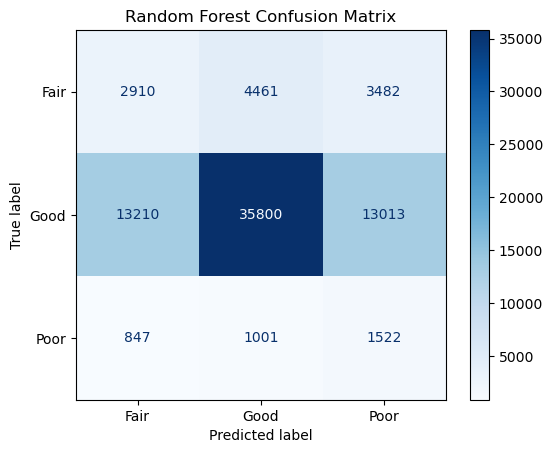

In [43]:
# Display Confusion Matrix 
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_pipeline.named_steps['classifier'].classes_)
disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show()

#### The confusion matrix visually confirms the class imbalance issue and the model's struggle to accurately distinguish between 'Fair' and 'Poor' health, often misclassifying them or misclassifying 'Good' trees into these minority categories.

## Milestone 3 

In [44]:
# GridSearchCV for Random Forest to find optimal hyperparameters
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

In [45]:
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time= 2.3min
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=300; total time= 6.3min


/Users/Bellevue/DSC530/miniconda3/envs/book_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time= 2.2min
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=300; total time= 6.4min
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time= 2.6min
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=300; total time= 6.4min
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time= 2.2min
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=200; total time= 3.9min
[CV] END classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=100; total time= 2.3min
[CV] END classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=200; total time= 3.5min
[CV] END classifier__max_depth=None, classifier_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['combined_diameter']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['spc_common',
                                                                          'boroname',
                                                                          'steward',
                                                                          'status',
                                                                          'size_category'])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='f1_weighted', verbose=2)

In [46]:
print("\nBest parameters for Random Forest:", rf_grid.best_params_)
print("Best F1-weighted score for Random Forest:", rf_grid.best_score_)


Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best F1-weighted score for Random Forest: 0.6017048423461521
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=200; total time= 4.1min
[CV] END classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=100; total time= 1.6min
[CV] END classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=100; total time= 2.5min
[CV] END classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=200; total time= 3.5min
[CV] END classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=300; total time= 5.4min
[CV] END classifier__max_depth=None, classifier__min_samples_split=10, classifier__n_estimators=300; total time= 5.0min
[CV] END classifier__max_depth=10, classifier__min_samples_split=5, classifier__n_estim

##### GridSearchCV has identified that a Random Forest model with 200 trees, no maximum depth constraint, and a minimum of 2 samples required to split a node, provides the best balance of precision and recall (as measured by F1-weighted score) during training, resulting in an average F1-weighted score of about 0.602 on the validation sets

In [47]:
# # Make predictions with the best Random Forest model
y_pred_rf_tuned = rf_grid.predict(X_test)

In [48]:
# # Evaluate tuned Random Forest performance
print("\nTuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_tuned))


Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

        Fair       0.17      0.27      0.21     10853
        Good       0.87      0.58      0.69     62023
        Poor       0.09      0.46      0.14      3370

    accuracy                           0.53     76246
   macro avg       0.38      0.43      0.35     76246
weighted avg       0.73      0.53      0.60     76246



##### The results show that the hyperparameter tuning with GridSearchCV did not lead to a significant improvement in the model's performance on the test set compared to the base Random Forest model, which already included class_weight='balanced'. The F1-weighted score, overall accuracy, and class-specific metrics remain virtually identical.

In [49]:
# # Confusion Matrix for tuned model
cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
print("\nTuned Random Forest Confusion Matrix:")
print(cm_rf_tuned)


Tuned Random Forest Confusion Matrix:
[[ 2881  4468  3504]
 [13026 35869 13128]
 [  829   993  1548]]


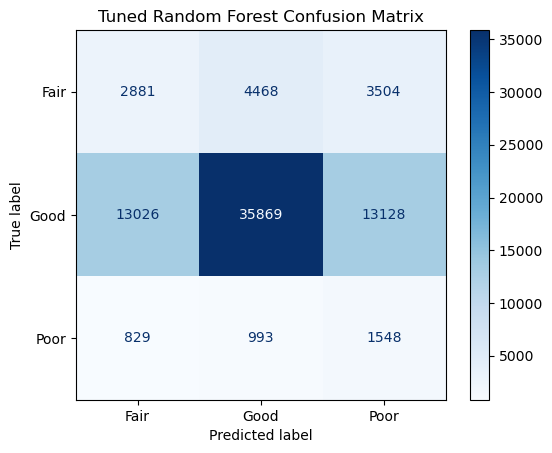

In [50]:
disp_rf_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_rf_tuned, display_labels=rf_grid.best_estimator_.named_steps['classifier'].classes_)
disp_rf_tuned.plot(cmap=plt.cm.Blues)
plt.title('Tuned Random Forest Confusion Matrix')
plt.show()

Fair - Correct (True Positive): 2,881 trees correctly predicted as Fair.
Misclassified:
* 4,468 predicted as Good
* 3,504 predicted as Poor
Model struggles with Fair trees — most are being predicted as Good or Poor.

Good - Correct (True Positive): 35,869
Misclassified:
* 13,026 predicted as Fair
* 13,128 predicted as Poor
Model does well on Good trees but still makes a lot of mistakes (about 43% are misclassified).

Poor - Correct (True Positive): 1,548
Misclassified:
* 993 predicted as Good
* 829 predicted as Fair
Poor trees are the least frequent and the hardest to predict. Accuracy here is low.

Summary: The model most confidently predicts "Good" trees, which is expected due to class imbalance (there are many more Good trees).

## Milestone 4

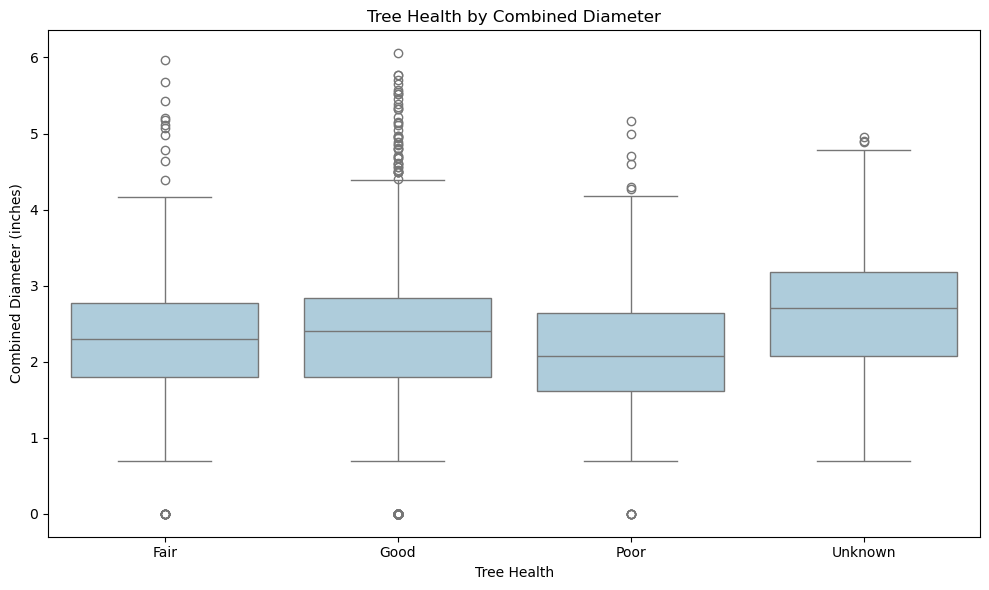

In [23]:
# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='health', y='combined_diameter_log')
plt.title('Tree Health by Combined Diameter')
plt.xlabel('Tree Health')
plt.ylabel('Combined Diameter (inches)')
plt.tight_layout()
plt.show()

/var/folders/rm/9b6561r12137sm0p138y31940000gn/T/ipykernel_94584/1523799686.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_diameter.values, y=avg_diameter.index, palette='crest')


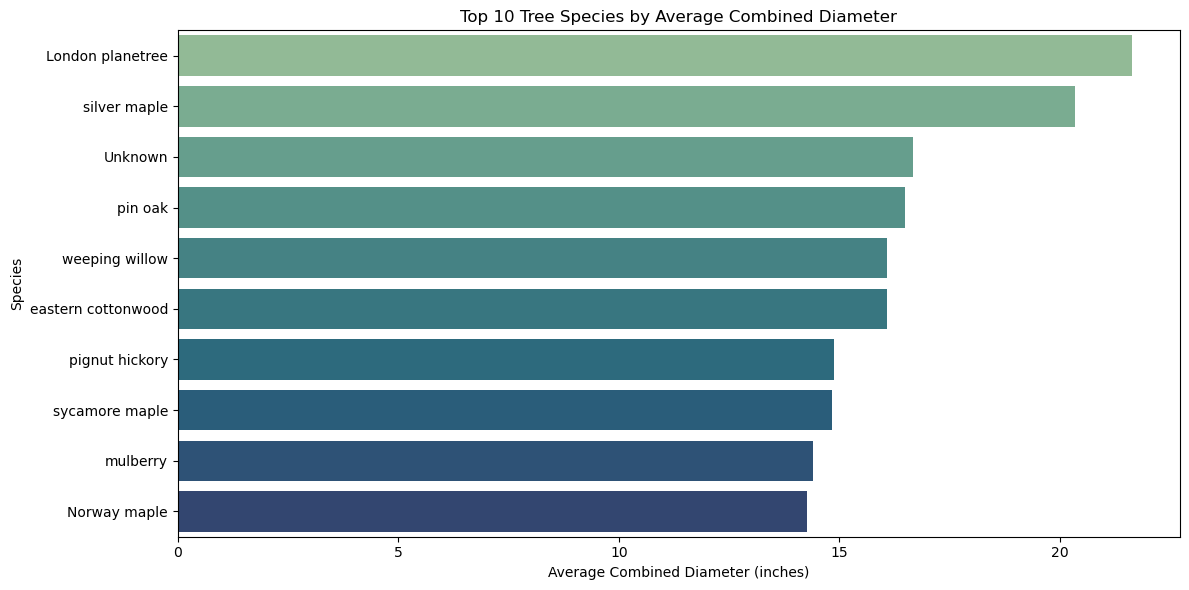

In [24]:
# Show trees average diameter to correlate with tree health
avg_diameter = data.groupby('spc_common')['combined_diameter'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_diameter.values, y=avg_diameter.index, palette='crest')
plt.xlabel('Average Combined Diameter (inches)')
plt.ylabel('Species')
plt.title('Top 10 Tree Species by Average Combined Diameter')
plt.tight_layout()
plt.show()